<a href="https://colab.research.google.com/github/sanasnaik/movie-recommender/blob/main/Data_Science_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: my project group gave me permission to post this code publicly. \\
See our final presentation here: https://docs.google.com/presentation/d/1evtR3QGjZXgl-TToY5H7LLgl7vJVoUrI7We7MO8zBkQ/edit?usp=sharing for our explanation of the entire planning, research, and experimental process.

# Basic Matrix Factorization Algorithm / SVD (Singular Value Decomposition) Algorithm

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357285 sha256=c590c65ed162a85ffa5a4d9c6541b21ba7bfccaf740c220d69c61e75634f6275
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Pre-process Data \\
Dataset selected: https://grouplens.org/datasets/movielens/latest/ (“Small” dataset)

In [ ]:
import pandas as pd
import numpy as np
import surprise as s

#  load ratings data into dataset class from surprise
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')
tags_df = pd.read_csv('tags.csv')

data = s.Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], s.Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max())))

train, test = s.model_selection.train_test_split(data, test_size=0.2)

Rating Predictions:

In [ ]:
svd = s.SVD()
svd.fit(train)
preds = svd.test(test)

#  evaluate predictions by calculating MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)
mae = s.accuracy.mae(preds)
rmse = s.accuracy.rmse(preds)

MAE:  0.6791
RMSE: 0.8824


# SVD Algorithm With Improved Accuracy


See the linked presentation for an explanation on how this improved our accuracy!

In [ ]:
import pandas as pd
import numpy as np
import surprise as s
from collections import defaultdict

# ---- adjust ratings based on genre preferences and imbalanced classes ---- #

ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')
movies_df['genres'] = movies_df['genres'].str.split('|')

ratings_w_genres = pd.merge(ratings_df, movies_df[['movieId', 'genres']], on='movieId')
user_genre_ratings = defaultdict(lambda: defaultdict(list))  #  each user's average rating for each genre

#  add each user's rating for each genre in dictionary
for _, row in ratings_w_genres.iterrows():
    userid = row['userId']
    rating = row['rating']
    for genre in row['genres']:
        user_genre_ratings[userid][genre].append(rating)

user_genre_preferences = {}  #  average rating for each genre per user
for user, genres in user_genre_ratings.items():
    user_genre_preferences[user] = {genre: sum(ratings) / len(ratings) for genre, ratings in genres.items()}

#  function to adjust ratings based on genre preference and inflate lower ratings
def adjust_rating(row):
    user_id = row['userId']
    genres = row['genres']
    base_rating = row['rating']

    #  add a boost based on user's preference for movie's genres
    if user_id in user_genre_preferences:
        genre_preferences = user_genre_preferences[user_id]
        boost = sum(genre_preferences.get(genre, 0) for genre in genres) / len(genres)
        genre_adjusted_rating = base_rating + 0.1 * (boost - base_rating)
    else:
        genre_adjusted_rating = base_rating

    #  inflate the importance of lower ratings
    if base_rating < 3:
        return genre_adjusted_rating * 1.5  # Apply inflation for low ratings
    else:
        return genre_adjusted_rating

ratings_w_genres['adjusted_rating'] = ratings_w_genres.apply(adjust_rating, axis=1)

#  load adjusted ratings into Surprise
reader = s.Reader(rating_scale=(ratings_w_genres['adjusted_rating'].min(), ratings_w_genres['adjusted_rating'].max()))
data = s.Dataset.load_from_df(ratings_w_genres[['userId', 'movieId', 'adjusted_rating']], reader)

#  create + train the SVD model
trainset, testset = s.model_selection.train_test_split(data, test_size=0.2)
model = s.SVD()
model.fit(trainset)

predictions = model.test(testset)

#  calculate MAE
mae = s.accuracy.mae(predictions)
print("MAE:", mae)

#  calculate RMSE
rmse = s.accuracy.rmse(predictions)
print("RMSE:", rmse)

# ---- get top 10 recommendations and calculate metrics ---- #

#  list of items that each user rated in the training set
trainset_rated_items = defaultdict(set)
for user_id, item_id, _ in trainset.all_ratings():
    trainset_rated_items[trainset.to_raw_uid(user_id)].add(trainset.to_raw_iid(item_id))

top_recommendations = defaultdict(list)

for user_id in trainset_rated_items.keys():
    #  predict ratings for all items that the user has not rated in the training set
    all_items = set(movies_df['movieId'].unique())
    rated_items = trainset_rated_items[user_id]
    unrated_items = all_items - rated_items

    #  get predicted ratings for each unrated item
    predictions_for_user = [(item, model.predict(user_id, item).est) for item in unrated_items]

    #  sort items and take top 10
    top_10_items = sorted(predictions_for_user, key=lambda x: x[1], reverse=True)[:10]
    top_recommendations[user_id] = [item for item, _ in top_10_items]

def calculate_metrics(predictions, top_recommendations):
    #  convert testset to dictionary
    test_ratings = defaultdict(set)
    for uid, iid, true_r, est, _ in predictions:
        if true_r >= 4.0:  #  consider items with rating >= 4.0 as relevant
            test_ratings[uid].add(iid)

    precisions, recalls, f_measures, ndcgs = [], [], [], []

    for uid, recommended_items in top_recommendations.items():
        relevant_items = test_ratings[uid]
        recommended_relevant_items = set(recommended_items) & relevant_items

        #  precision calculation
        precision = len(recommended_relevant_items) / len(recommended_items) if recommended_items else 0
        precisions.append(precision)

        #  recall calculation
        recall = len(recommended_relevant_items) / len(relevant_items) if relevant_items else 0
        recalls.append(recall)

        #  F-measure calculation
        if precision + recall > 0:
            f_measure = 2 * precision * recall / (precision + recall)
        else:
            f_measure = 0
        f_measures.append(f_measure)

        #  NDCG calculation
        dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(recommended_items) if item in relevant_items])
        idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(relevant_items), len(recommended_items)))])
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)

    #  average metrics across all users
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f_measure = np.mean(f_measures)
    avg_ndcg = np.mean(ndcgs)

    print(f"Precision: {avg_precision}")
    print(f"Recall: {avg_recall}")
    print(f"F-measure: {avg_f_measure}")
    print(f"NDCG: {avg_ndcg}")

calculate_metrics(predictions, top_recommendations)

MAE:  0.5019
MAE: 0.5018843564841111
RMSE: 0.6596
RMSE: 0.6596029352475904
Precision: 0.027704918032786883
Recall: 0.03630471644396914
F-measure: 0.0243269166790516
NDCG: 0.04109711056977658


#NCF with Weight/Inflation:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

# Preprocess
ratings_df = ratings_df.drop(columns=['timestamp'])
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_df['title'] = movies_df['title'].str.replace(r' \(\d{4}\)', '', regex=True)

# Merge and split oclumns for one hot encoding
data = pd.merge(ratings_df, movies_df[['movieId', 'title', 'year', 'genres']], on='movieId', how='left')
genres_list = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
               'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_columns = genres_list
data['genres'] = data['genres'].fillna('')
for genre in genres_list:
    data[genre] = data['genres'].apply(lambda x: 1 if genre in str(x) else 0)

# Drop these rows: genre and title
data = data.drop(columns=['genres', 'title']).dropna()

# Analyze rating distribution and apply to get weighted ratings
rating_counts = data['rating'].value_counts().sort_index()
total_ratings = rating_counts.sum()
weights = {rating: total_ratings / (rating_counts[rating] * len(rating_counts)) for rating in rating_counts.index}
data['weighted_rating'] = data['rating'].apply(lambda x: x * weights[x])

# Display data for preview purposes
data

,userId,movieId,rating,year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,weighted_rating
0,1,1,4.0,1995,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1.502871
1,1,3,4.0,1995,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1.502871
2,1,6,4.0,1995,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1.502871
3,1,47,5.0,1995,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3.816112
4,1,50,5.0,1995,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,3.816112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1.502871
100832,610,168248,5.0,2017,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3.816112
100833,610,168250,5.0,2017,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3.816112
100834,610,168252,5.0,2017,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3.816112


hyperparemter tuning SGD resulted in the following (code was lost but screenshot of this was taken):

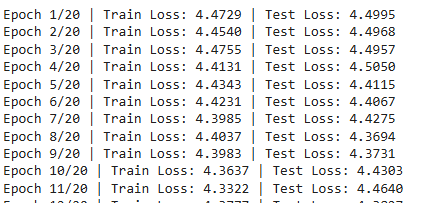

hyperparemter for batch size 32 resulted in the following (code was lost but screenshot of this was taken):

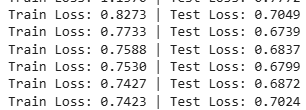

hyperparmeter tuning:  
batch size: 64, lr: 0.0007, weight_decay: 0.03, batch_size: 64

Using device: cuda
Epoch 1/20 | Train Loss: 1.2083 | Test Loss: 0.8402
Epoch 2/20 | Train Loss: 0.8818 | Test Loss: 0.7404
Epoch 3/20 | Train Loss: 0.7749 | Test Loss: 0.7504
Epoch 4/20 | Train Loss: 0.7116 | Test Loss: 0.6361
Epoch 5/20 | Train Loss: 0.6847 | Test Loss: 0.6151
Epoch 6/20 | Train Loss: 0.6770 | Test Loss: 0.6305
Epoch 7/20 | Train Loss: 0.6727 | Test Loss: 0.6957
Epoch 8/20 | Train Loss: 0.6698 | Test Loss: 0.6102
Epoch 9/20 | Train Loss: 0.6692 | Test Loss: 0.6122
Epoch 10/20 | Train Loss: 0.6692 | Test Loss: 0.6107
Epoch 11/20 | Train Loss: 0.6622 | Test Loss: 0.6344
Epoch 12/20 | Train Loss: 0.6619 | Test Loss: 0.6069
Epoch 13/20 | Train Loss: 0.6545 | Test Loss: 0.6004
Epoch 14/20 | Train Loss: 0.6536 | Test Loss: 0.6258
Epoch 15/20 | Train Loss: 0.6614 | Test Loss: 0.6024
Epoch 16/20 | Train Loss: 0.6570 | Test Loss: 0.6166
Epoch 17/20 | Train Loss: 0.6549 | Test Loss: 0.6045
Epoch 18/20 | Train Loss: 0.6541 | Test Loss: 0.6033
Epoch 19/20 | Train Loss: 0.6573 | T

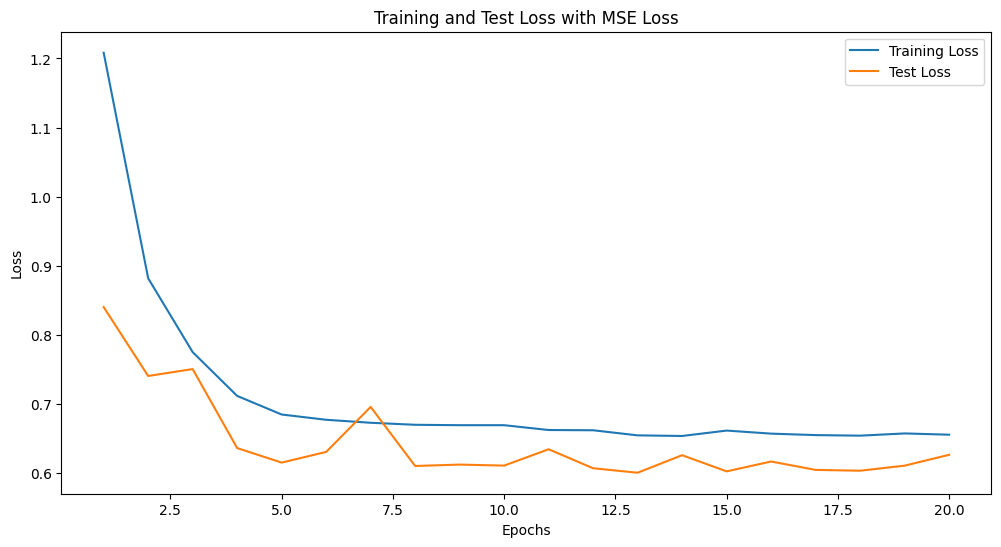

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

# Prepare features and target
X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']  # Keep the target as 'rating'

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Convert cause data needs to be tensors
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# NCF Model:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model
def train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs):
    mse_loss = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mse_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mse_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=0.1)

# Train model
epochs = 20
train_losses, test_losses = train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MSE Loss')
plt.legend()
plt.show()

hyperparmeter tuning:  
batch size: 64, lr: 0.001, weight_decay: 0.01, batch_size: 64

Using device: cpu
Epoch 1/20 | Train Loss: 1.1097 | Test Loss: 0.7587
Epoch 2/20 | Train Loss: 0.7708 | Test Loss: 0.6209
Epoch 3/20 | Train Loss: 0.6672 | Test Loss: 0.6089
Epoch 4/20 | Train Loss: 0.6178 | Test Loss: 0.5843
Epoch 5/20 | Train Loss: 0.5879 | Test Loss: 0.5440
Epoch 6/20 | Train Loss: 0.5832 | Test Loss: 0.5876
Epoch 7/20 | Train Loss: 0.5834 | Test Loss: 0.5551
Epoch 8/20 | Train Loss: 0.5752 | Test Loss: 0.5444
Epoch 9/20 | Train Loss: 0.5739 | Test Loss: 0.5425
Epoch 10/20 | Train Loss: 0.5726 | Test Loss: 0.5469
Epoch 11/20 | Train Loss: 0.5678 | Test Loss: 0.5621
Epoch 12/20 | Train Loss: 0.5653 | Test Loss: 0.5218
Epoch 13/20 | Train Loss: 0.5627 | Test Loss: 0.5299
Epoch 14/20 | Train Loss: 0.5608 | Test Loss: 0.5315
Epoch 15/20 | Train Loss: 0.5610 | Test Loss: 0.5265
Epoch 16/20 | Train Loss: 0.5627 | Test Loss: 0.5464
Epoch 17/20 | Train Loss: 0.5635 | Test Loss: 0.5481
Epoch 18/20 | Train Loss: 0.5626 | Test Loss: 0.5287
Epoch 19/20 | Train Loss: 0.5660 | Te

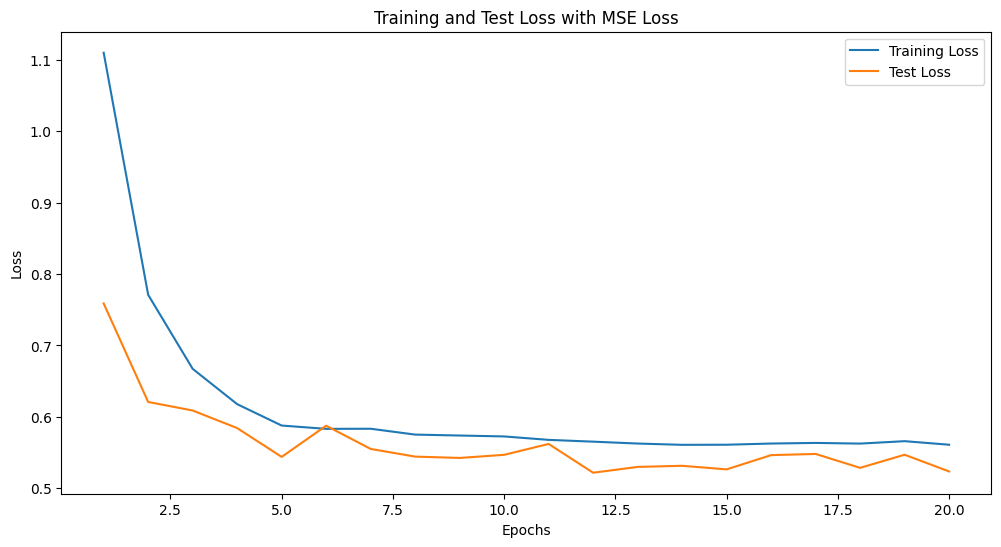

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

# Prepare features and target
X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']  # Keep the target as 'rating'

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Convert cause data needs to be tensors
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# NCF Model:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model
def train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs):
    mse_loss = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mse_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mse_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Train model
epochs = 20
train_losses, test_losses = train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MSE Loss')
plt.legend()
plt.show()

hyperparmeter tuning:
batch size: 64, lr: 0.0001, weight_decay: 0.02, batch_size: 64

Using device: cpu
Epoch 1/50 | Train Loss: 1.7203 | Test Loss: 0.9768
Epoch 2/50 | Train Loss: 1.0497 | Test Loss: 0.8686
Epoch 3/50 | Train Loss: 0.9534 | Test Loss: 0.8265
Epoch 4/50 | Train Loss: 0.9037 | Test Loss: 0.7810
Epoch 5/50 | Train Loss: 0.8822 | Test Loss: 0.7810
Epoch 6/50 | Train Loss: 0.8663 | Test Loss: 0.8019
Epoch 7/50 | Train Loss: 0.8489 | Test Loss: 0.7506
Epoch 8/50 | Train Loss: 0.8272 | Test Loss: 0.7429
Epoch 9/50 | Train Loss: 0.7954 | Test Loss: 0.7131
Epoch 10/50 | Train Loss: 0.7644 | Test Loss: 0.6790
Epoch 11/50 | Train Loss: 0.7324 | Test Loss: 0.6506
Epoch 12/50 | Train Loss: 0.6951 | Test Loss: 0.6566
Epoch 13/50 | Train Loss: 0.6685 | Test Loss: 0.6151
Epoch 14/50 | Train Loss: 0.6473 | Test Loss: 0.5867
Epoch 15/50 | Train Loss: 0.6343 | Test Loss: 0.5883
Epoch 16/50 | Train Loss: 0.6211 | Test Loss: 0.6075
Epoch 17/50 | Train Loss: 0.6086 | Test Loss: 0.5755
Epoch 18/50 | Train Loss: 0.6016 | Test Loss: 0.6293
Epoch 19/50 | Train Loss: 0.5910 | Te

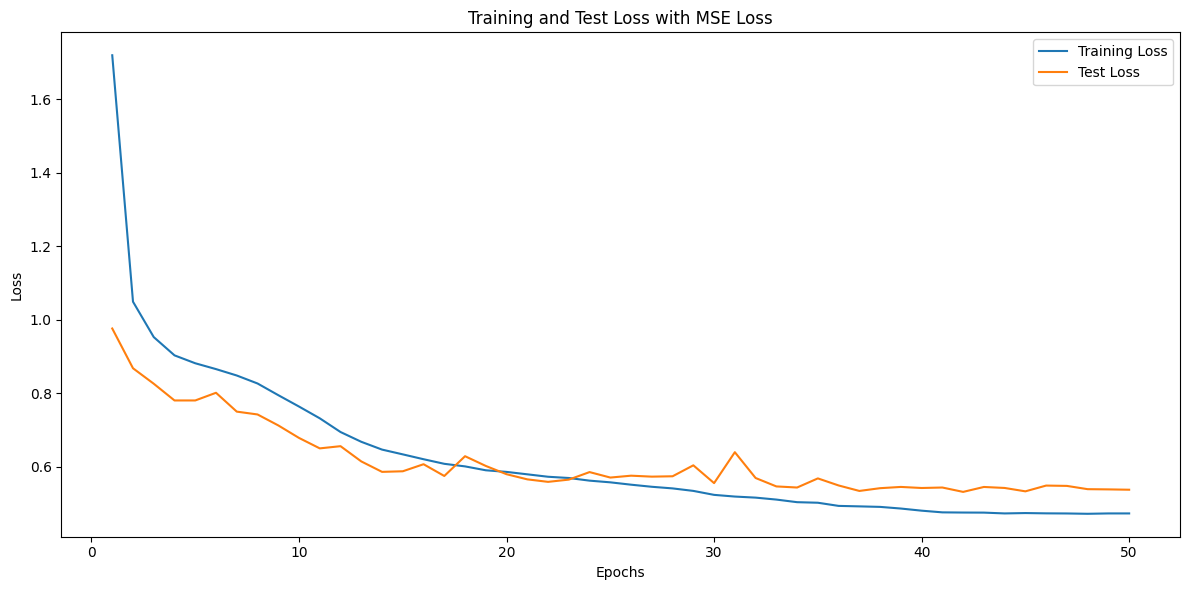

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

# Prepare features and target
X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']  # Keep the target as 'rating'

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Convert cause data needs to be tensors
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# NCF Model:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model
def train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs):
    mse_loss = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mse_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mse_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.02)

# Train model
epochs = 20
train_losses, test_losses = train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MSE Loss')
plt.legend()
plt.show()

Using device: cuda
Epoch 1/50 | Train Loss: 1.7203 | Test Loss: 1.0768
Epoch 2/50 | Train Loss: 1.2201 | Test Loss: 0.9986
Epoch 3/50 | Train Loss: 1.1023 | Test Loss: 0.9765
Epoch 4/50 | Train Loss: 1.0421 | Test Loss: 0.9123
Epoch 5/50 | Train Loss: 1.0123 | Test Loss: 0.9062
Epoch 6/50 | Train Loss: 0.9802 | Test Loss: 0.8921
Epoch 7/50 | Train Loss: 0.9487 | Test Loss: 0.8743
Epoch 8/50 | Train Loss: 0.9214 | Test Loss: 0.8595
Epoch 9/50 | Train Loss: 0.8961 | Test Loss: 0.8321
Epoch 10/50 | Train Loss: 0.8753 | Test Loss: 0.8122
Epoch 11/50 | Train Loss: 0.8485 | Test Loss: 0.7904
Epoch 12/50 | Train Loss: 0.8203 | Test Loss: 0.7738
Epoch 13/50 | Train Loss: 0.7991 | Test Loss: 0.7572
Epoch 14/50 | Train Loss: 0.7832 | Test Loss: 0.7484
Epoch 15/50 | Train Loss: 0.7695 | Test Loss: 0.7385
Epoch 16/50 | Train Loss: 0.7576 | Test Loss: 0.7301
Epoch 17/50 | Train Loss: 0.7462 | Test Loss: 0.7204
Epoch 18/50 | Train Loss: 0.7345 | Test Loss: 0.7113
Epoch 19/50 | Train Loss: 0.7236 | T

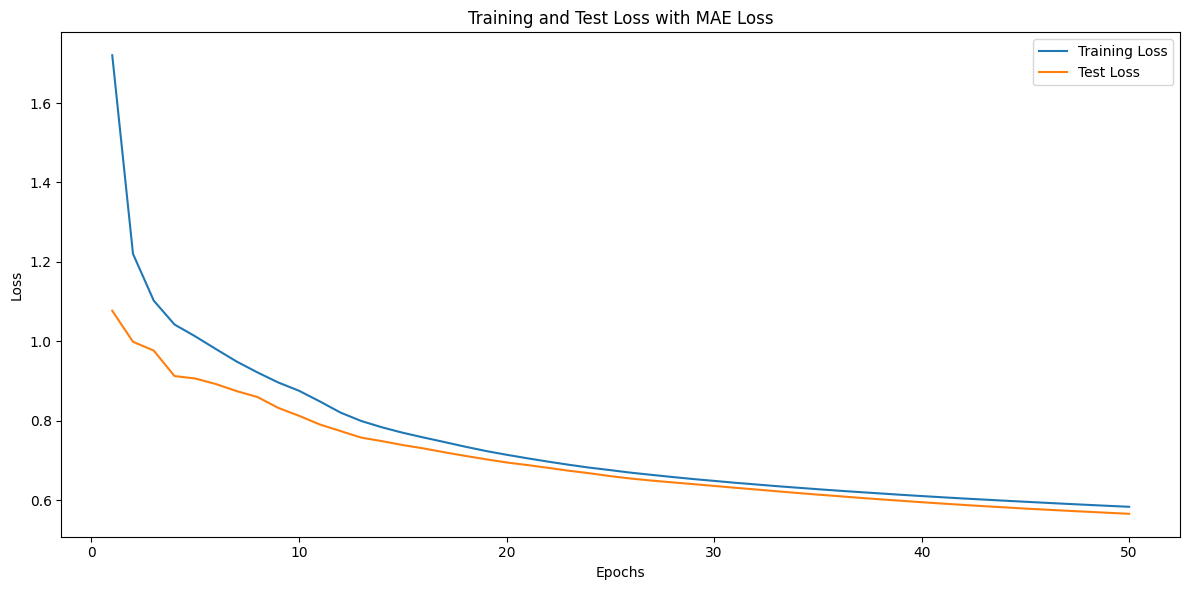

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# use cuda if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

# Prepare features and target
X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']  # Keep the target as 'rating'

# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Convert cause data needs to be tensors
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# NCF Model:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model with MAE loss
def train_and_evaluate_model_mae(model, train_loader, test_loader, optimizer, epochs):
    mae_loss = nn.L1Loss()  # MAE loss function
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mae_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mae_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0007, weight_decay=0.1)

# Train model
epochs = 20
train_losses, test_losses = train_and_evaluate_model_mae(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MAE Loss')
plt.legend()
plt.show()

Reccomendations

In [ ]:
all_items = set(data['movieId'].unique())
recommendations = {}

model.eval()  # Set to evaluation mode
# Applying Process from Chad's Slides:
with torch.no_grad():
    for user_id in data['userId'].unique():
        rated_items = set(train_data[train_data['userId'] == user_id]['movieId'].unique())
        candidate_items = torch.tensor(list(all_items - rated_items), dtype=torch.long).to(device)
        user_tensor = torch.tensor([user_id] * len(candidate_items), dtype=torch.long).to(device)
        genres_placeholder = torch.zeros((len(candidate_items), len(genre_columns)), dtype=torch.float).to(device)
        weighted_placeholder = torch.zeros(len(candidate_items), dtype=torch.float).to(device)
        scores = model(user_tensor, candidate_items, genres_placeholder, weighted_placeholder).squeeze()
        top_10_items = candidate_items[torch.topk(scores, 10).indices]
        recommendations[user_id] = top_10_items.tolist()

# Calculate the metrics
def calculate_metrics(recommendations, test_data):
    precisions, recalls, f_measures, ndcgs = [], [], [], []

    for user_id, recommended_items in recommendations.items():
        # Get actual items the user rated in test set
        actual_items = set(test_data[test_data['userId'] == user_id]['movieId'].unique())

        # Precision and Recall
        recommended_set = set(recommended_items)
        true_positives = len(recommended_set & actual_items)

        precision = true_positives / len(recommended_set) if recommended_set else 0
        recall = true_positives / len(actual_items) if actual_items else 0

        # F-measure
        f_measure = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        # NDCG
        dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(recommended_items) if item in actual_items])
        idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(actual_items), 10))])
        ndcg = dcg / idcg if idcg > 0 else 0

        # Metrics
        precisions.append(precision)
        recalls.append(recall)
        f_measures.append(f_measure)
        ndcgs.append(ndcg)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f_measure = np.mean(f_measures)
    avg_ndcg = np.mean(ndcgs)

    return avg_precision, avg_recall, avg_f_measure, avg_ndcg

# Evaluate
avg_precision, avg_recall, avg_f_measure, avg_ndcg = calculate_metrics(recommendations, test_data)
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F-measure: {avg_f_measure:.4f}")
print(f"NDCG: {avg_ndcg:.4f}")

Precision: 0.0761
Recall: 0.0303
F-measure: 0.0336
NDCG: 0.0626


# NCF with Genre Preferences Accounted in Data + Weights/Inflations

In [ ]:
import pandas as pd
from collections import defaultdict

movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
movies_df['genres'] = movies_df['genres'].str.split('|')

# One-hot encoding for genres
genres_list = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
    'Sci-Fi', 'Thriller', 'War', 'Western']

genre_columns = genres_list

# Initialize one-hot columns
for genre in genres_list:
    movies_df[genre] = movies_df['genres'].apply(lambda x: 1 if genre in x else 0)

# Merge ratings w/ movies to include genres and one-hot encoding
ratings_w_genres = pd.merge(ratings_df, movies_df, on='movieId')

# Applying Sana's genre preference
user_genre_ratings = defaultdict(lambda: defaultdict(list))
for _, row in ratings_w_genres.iterrows():
    user_id = row['userId']
    rating = row['rating']
    for genre in row['genres']:
        user_genre_ratings[user_id][genre].append(rating)

user_genre_preferences = {user: {genre: sum(ratings) / len(ratings) for genre, ratings in genres.items()} for user,genres in user_genre_ratings.items()}
def adjust_rating(row):
    user_id = row['userId']
    genres = row['genres']
    base_rating = row['rating']
    if user_id in user_genre_preferences:
        genre_preferences = user_genre_preferences[user_id]
        genre_boost = sum(genre_preferences.get(genre, 0) for genre in genres) / len(genres)
        genre_adjusted_rating = base_rating + 0.1 * (genre_boost - base_rating)  # Scale the boost as needed
    else:
        genre_adjusted_rating = base_rating
    if base_rating < 3:
        return genre_adjusted_rating * 1.5  # Apply inflation for low ratings
    else:
        return genre_adjusted_rating

# Column manipulations:
ratings_w_genres['adjusted_rating'] = ratings_w_genres.apply(adjust_rating, axis=1)
ratings_w_genres['weighted_rating'] = ratings_w_genres['adjusted_rating']
ratings_w_genres = ratings_w_genres.drop(columns=['adjusted_rating'])
ratings_w_genres = ratings_w_genres.drop(columns=['genres'])
ratings_w_genres['year'] = ratings_w_genres['title'].str.extract(r'\((\d{4})\)', expand=False)
ratings_w_genres = ratings_w_genres.drop(columns=['title'])
ratings_w_genres = ratings_w_genres.drop(columns=['timestamp'])

# preview data
data = ratings_w_genres
data

,userId,movieId,rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,weighted_rating,year
0,1,1,4.0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,4.044010,1995
1,1,3,4.0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,4.029240,1995
2,1,6,4.0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.027441,1995
3,1,47,5.0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,4.915606,1995
4,1,50,5.0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,4.922256,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100245,610,166534,4.0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,3.965626,2017
100246,610,168248,5.0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.866406,2017
100247,610,168250,5.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4.851365,2017
100248,610,168252,5.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,4.863165,2017


Using device: cuda
Epoch 1/10 | Train Loss: 0.9146 | Test Loss: 1.0619
Epoch 2/10 | Train Loss: 0.3634 | Test Loss: 0.4474
Epoch 3/10 | Train Loss: 0.3310 | Test Loss: 0.3294
Epoch 4/10 | Train Loss: 0.3133 | Test Loss: 0.2462
Epoch 5/10 | Train Loss: 0.3026 | Test Loss: 0.2297
Epoch 6/10 | Train Loss: 0.2962 | Test Loss: 0.2187
Epoch 7/10 | Train Loss: 0.2892 | Test Loss: 0.2124
Epoch 8/10 | Train Loss: 0.2829 | Test Loss: 0.2189
Epoch 9/10 | Train Loss: 0.2782 | Test Loss: 0.2074
Epoch 10/10 | Train Loss: 0.2772 | Test Loss: 0.2073


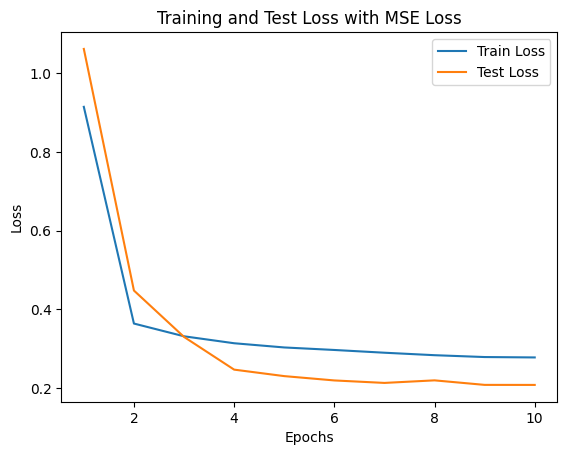

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Doing same stuff from previous code blocks for training NCF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values


X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Update the Neural Collaborative Filtering (NCF) model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)  # Handle weighted_rating as a feature
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),  # Update input size: user + item + genres + weighted
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model
def train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs):
    mse_loss = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mse_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mse_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)

# Train model
epochs = 10 # Only 10 epochs since it takes a very, very long time for code to run epoch
train_losses, test_losses = train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MSE Loss')
plt.legend()
plt.show()

Using device: cuda
Epoch 1/10 | Train Loss: 0.7232 | Test Loss: 0.8397
Epoch 2/10 | Train Loss: 0.2900 | Test Loss: 0.3595
Epoch 3/10 | Train Loss: 0.2954 | Test Loss: 0.2912
Epoch 4/10 | Train Loss: 0.2669 | Test Loss: 0.2140
Epoch 5/10 | Train Loss: 0.2385 | Test Loss: 0.1826
Epoch 6/10 | Train Loss: 0.2427 | Test Loss: 0.1877
Epoch 7/10 | Train Loss: 0.2665 | Test Loss: 0.1865
Epoch 8/10 | Train Loss: 0.2424 | Test Loss: 0.2036
Epoch 9/10 | Train Loss: 0.2275 | Test Loss: 0.1724
Epoch 10/10 | Train Loss: 0.2536 | Test Loss: 0.1835


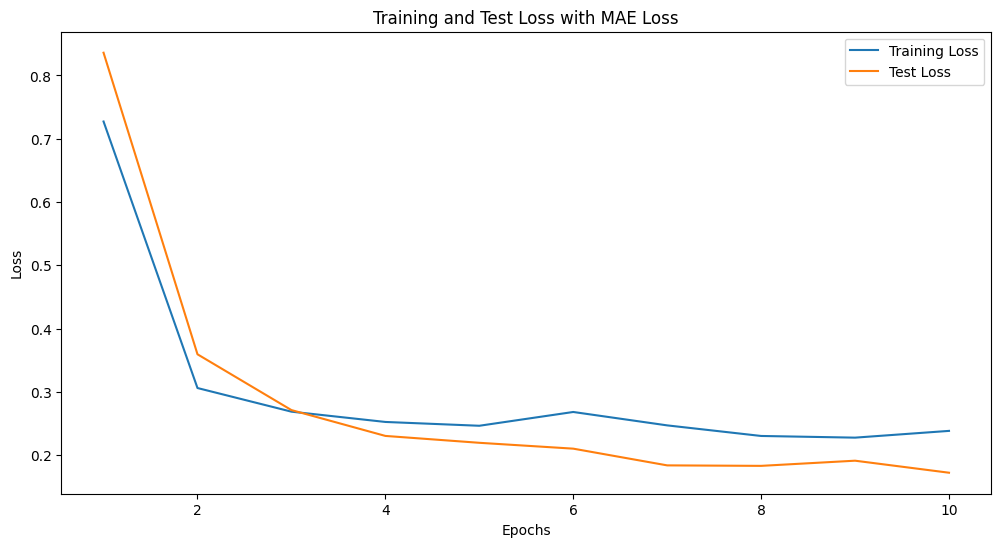

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error  # Import MAE
import numpy as np
import matplotlib.pyplot as plt

# Doing same stuff from previous code blocks for training NCF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_users = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_items = torch.tensor(train_data['movieId'].values, dtype=torch.long).to(device)
train_genres = torch.tensor(train_data[genre_columns].values, dtype=torch.float).to(device)
train_weighted = torch.tensor(train_data['weighted_rating'].values, dtype=torch.float).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float).to(device)
test_users = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_items = torch.tensor(test_data['movieId'].values, dtype=torch.long).to(device)
test_genres = torch.tensor(test_data[genre_columns].values, dtype=torch.float).to(device)
test_weighted = torch.tensor(test_data['weighted_rating'].values, dtype=torch.float).to(device)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Update the Neural Collaborative Filtering (NCF) model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)  # Handle weighted_rating as a feature
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),  # Update input size: user + item + genres + weighted
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))  # Ensure weighted is treated as a single feature
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate the model with MAE
def train_and_evaluate_model_mae(model, train_loader, test_loader, optimizer, epochs):
    mae_loss = nn.L1Loss()  # Use L1Loss for MAE
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mae_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mae_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)

# Train model
epochs = 10  # Use a smaller number of epochs for quick testing
train_losses, test_losses = train_and_evaluate_model_mae(model, train_loader, test_loader, optimizer, epochs)

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss with MAE Loss')
plt.legend()
plt.show()

In [ ]:
all_items = set(data['movieId'].unique())
recommendations = {}

model.eval()  # Set to evaluation mode
# Applying Process from Chad's Slides:
with torch.no_grad():
    for user_id in data['userId'].unique():
        rated_items = set(train_data[train_data['userId'] == user_id]['movieId'].unique())
        candidate_items = torch.tensor(list(all_items - rated_items), dtype=torch.long).to(device)
        user_tensor = torch.tensor([user_id] * len(candidate_items), dtype=torch.long).to(device)
        genres_placeholder = torch.zeros((len(candidate_items), len(genre_columns)), dtype=torch.float).to(device)
        weighted_placeholder = torch.zeros(len(candidate_items), dtype=torch.float).to(device)
        scores = model(user_tensor, candidate_items, genres_placeholder, weighted_placeholder).squeeze()
        top_10_items = candidate_items[torch.topk(scores, 10).indices]
        recommendations[user_id] = top_10_items.tolist()

# Calculate the metrics
def calculate_metrics(recommendations, test_data):
    precisions, recalls, f_measures, ndcgs = [], [], [], []

    for user_id, recommended_items in recommendations.items():
        # Get actual items the user rated in test set
        actual_items = set(test_data[test_data['userId'] == user_id]['movieId'].unique())

        # Precision and Recall
        recommended_set = set(recommended_items)
        true_positives = len(recommended_set & actual_items)

        precision = true_positives / len(recommended_set) if recommended_set else 0
        recall = true_positives / len(actual_items) if actual_items else 0

        # F-measure
        f_measure = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        # NDCG
        dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(recommended_items) if item in actual_items])
        idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(actual_items), 10))])
        ndcg = dcg / idcg if idcg > 0 else 0

        # Metrics
        precisions.append(precision)
        recalls.append(recall)
        f_measures.append(f_measure)
        ndcgs.append(ndcg)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_f_measure = np.mean(f_measures)
    avg_ndcg = np.mean(ndcgs)

    return avg_precision, avg_recall, avg_f_measure, avg_ndcg

# Evaluate
avg_precision, avg_recall, avg_f_measure, avg_ndcg = calculate_metrics(recommendations, test_data)
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F-measure: {avg_f_measure:.4f}")
print(f"NDCG: {avg_ndcg:.4f}")

Precision: 0.0961
Recall: 0.0503
F-measure: 0.0496
NDCG: 0.0880


#NCF With Robustness and Anti-attacks for Recommender Systems


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#Doing the same as NCF with ewights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data['userId'] = data['userId'].astype('category').cat.codes.values
data['movieId'] = data['movieId'].astype('category').cat.codes.values

X = data[['userId', 'movieId', 'weighted_rating'] + genre_columns]
y = data['rating']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare data for PyTorch
def prepare_data(data, genre_columns, device):
    users = torch.tensor(data['userId'].values, dtype=torch.long).to(device)
    items = torch.tensor(data['movieId'].values, dtype=torch.long).to(device)
    genres = torch.tensor(data[genre_columns].values, dtype=torch.float).to(device)
    weighted = torch.tensor(data['weighted_rating'].values, dtype=torch.float).to(device)
    ratings = torch.tensor(data['rating'].values, dtype=torch.float).to(device)
    return users, items, genres, weighted, ratings

train_users, train_items, train_genres, train_weighted, train_ratings = prepare_data(train_data, genre_columns, device)
test_users, test_items, test_genres, test_weighted, test_ratings = prepare_data(test_data, genre_columns, device)

train_dataset = TensorDataset(train_users, train_items, train_genres, train_weighted, train_ratings)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(test_users, test_items, test_genres, test_weighted, test_ratings)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Collaborative Filtering (NCF) model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64):
        super(NCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc_genres = nn.Linear(len(genre_columns), embedding_dim)
        self.fc_weighted = nn.Linear(1, embedding_dim)
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, item, genres, weighted):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.fc_genres(genres)
        weighted_emb = self.fc_weighted(weighted.unsqueeze(1))
        x = torch.cat([user_emb, item_emb, genre_emb, weighted_emb], dim=-1)
        x = self.fc_layers(x)
        return x

num_users = data['userId'].nunique()
num_items = data['movieId'].nunique()
model = NCF(num_users, num_items, embedding_dim=64).to(device)

# Train and evaluate
def train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs):
    mse_loss = nn.MSELoss()
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for user, item, genres, weighted, rating in train_loader:
            optimizer.zero_grad()
            predictions = model(user, item, genres, weighted).squeeze()
            loss = mse_loss(predictions, rating)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for user, item, genres, weighted, rating in test_loader:
                predictions = model(user, item, genres, weighted).squeeze()
                loss = mse_loss(predictions, rating)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.05)
epochs = 10
train_losses, test_losses = train_and_evaluate_model_mse(model, train_loader, test_loader, optimizer, epochs)

# Robustness evaluation
def inject_adversarial_noise(data, noise_ratio=0.1, noise_scale=0.5):
    num_samples = int(len(data) * noise_ratio)
    adversarial_data = data.sample(num_samples).copy()
    adversarial_data['rating'] += np.random.normal(0, noise_scale, num_samples)
    adversarial_data['rating'] = adversarial_data['rating'].clip(0, 5)
    return pd.concat([data, adversarial_data], ignore_index=True)

def evaluate_robustness(model, test_data, genre_columns, noise_ratios, noise_scale):
    robust_metrics = []
    for noise_ratio in noise_ratios:
        adversarial_test_data = inject_adversarial_noise(test_data, noise_ratio, noise_scale)
        adv_users, adv_items, adv_genres, adv_weighted, adv_ratings = prepare_data(adversarial_test_data, genre_columns, device)

        # Perform prediction and calculate MSE
        model.eval()
        with torch.no_grad():
            predictions = model(adv_users, adv_items, adv_genres, adv_weighted).squeeze()
        mse_model = mean_squared_error(adv_ratings.cpu(), predictions.cpu())

        robust_metrics.append((noise_ratio, mse_model))
        print(f"Noise Ratio: {noise_ratio:.2f}, MSE on Adversarial Data: {mse_model:.4f}")
    return robust_metrics


# Noise ratios and scale
noise_ratios = [0.05, 0.10, 0.20, 0.30]  # Fraction of data with noise
noise_scale = 0.5  # Scale of noise

# Evaluate robustness
robustness_results = evaluate_robustness(
    model, test_data, genre_columns, noise_ratios, noise_scale
)

# Plot robustness results
plt.figure(figsize=(10, 6))
noise_ratios, mse_scores = zip(*robustness_results)
plt.plot(noise_ratios, mse_scores, marker='o')
plt.xlabel('Noise Ratio')
plt.ylabel('Mean Squared Error')
plt.title('Robustness Evaluation: MSE vs. Noise Ratio')
plt.grid()
plt.show()

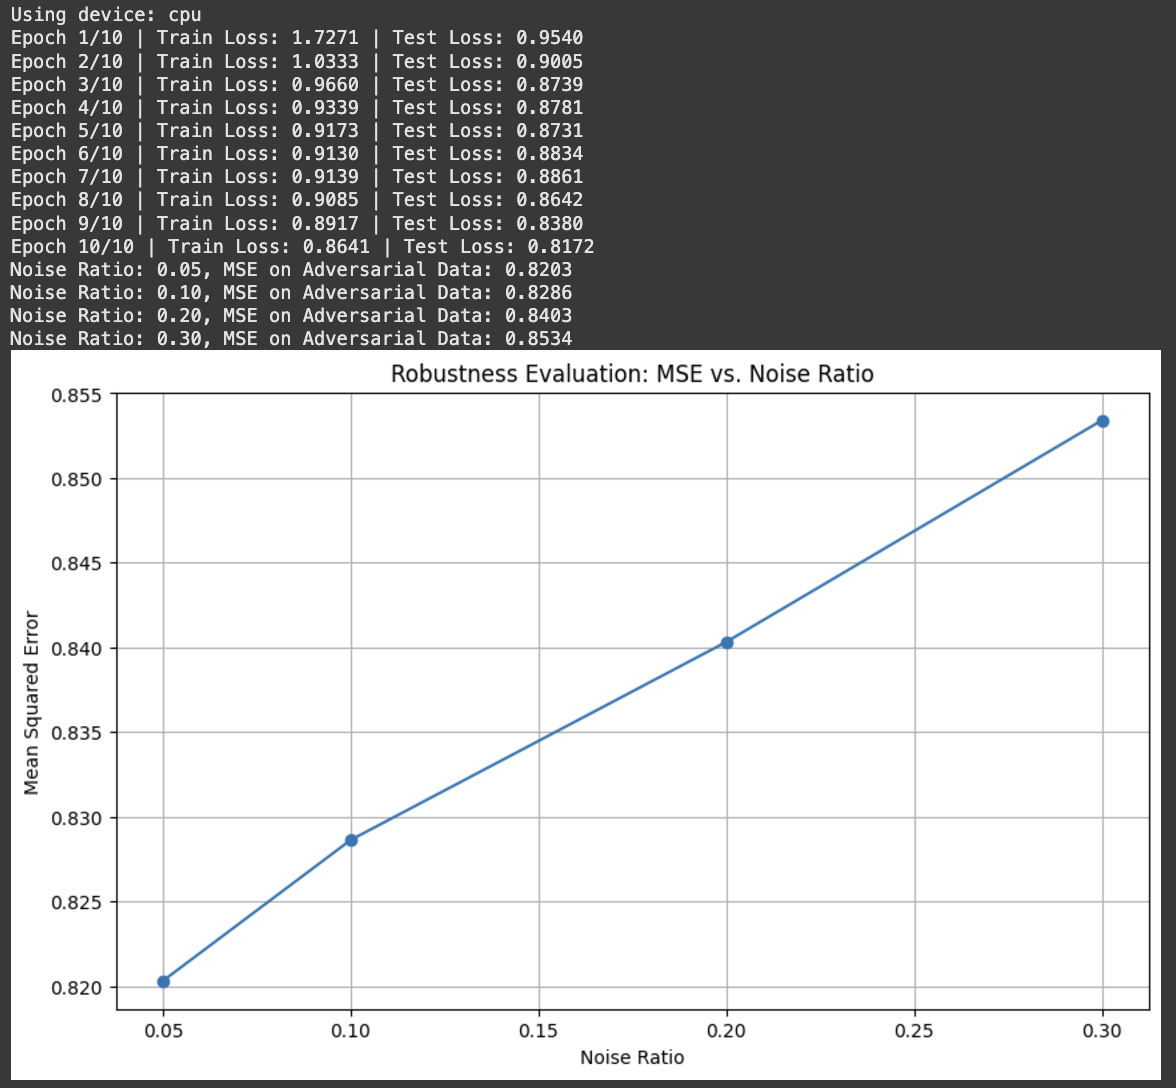